#### Here we'll take the extracted data from the Data_extraction layer and clean it using pyspark and some pandas

In [129]:
# Import necessary dependencies
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import col 
from pyspark.sql.types import StringType
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import time

In [128]:
# Set environment variables for Java, Spark, and Hadoop
os.environ["PYSPARK_PYTHON"] = r"C:\Users\Nel\AppData\Local\Programs\Python\Python311\python.exe"  # Replace with your Python path
os.environ["JAVA_HOME"] = r"C:\Program Files\Java\jdk-17"  # Replace with your Java JDK path
os.environ["SPARK_HOME"] = r"C:\Spark"  # Replace with your Spark installation path
os.environ["HADOOP_HOME"] = r"C:\Hadoop"  # Required if running Spark with Hadoop dependencies

# Add Spark and Hadoop binaries to the system PATH
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["SPARK_HOME"], "bin")
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["HADOOP_HOME"], "bin")


In [3]:
# Initialise our spark session
spark = SparkSession.builder.appName('GlobalStayETL').getOrCreate()

In [4]:
spark

In [5]:
# Next is to create a dataframe from the extracted data using pandas
df = pd.read_csv('House_listings\merged_airbnb_listings.csv')

C:\Users\Nel\AppData\Local\Temp\ipykernel_17348\2881984375.py:2: DtypeWarning: Columns (4,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('House_listings\merged_airbnb_listings.csv')


In [6]:
# Lets check the number of rows and columns of the data
df.shape

(1475478, 20)

In [7]:
# Next let work with a fraction of the data, we'll call this fraction sample_data
sample_data = df.sample(frac=0.01, random_state=1)

In [8]:
# Now ;let's check the number of rows and columns of the sample data
sample_data.shape

(14755, 20)

In [9]:
# To make cleaning easier, we should convert all of the columns in the sample_data to strings
sample_data = sample_data.astype(str)

In [10]:
# For convinence, we should save that sample_data as a csv file
sample_data.to_csv('House_listings/sample_data_of_merged_airbnb_listings.csv', index=False)

In [166]:
# Now let's switch over to spark and create the a spark dataframe from the sample_data
listing_df = spark.createDataFrame(sample_data)

In [12]:
listing_df.show(10)

+-------------------+--------------------+---------+---------------+-------------------+--------------------+------------------+------------------+---------------+------+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+------------------+--------------------+--------+
|                 id|                name|  host_id|      host_name|neighbourhood_group|       neighbourhood|          latitude|         longitude|      room_type| price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|           license|             country|currency|
+-------------------+--------------------+---------+---------------+-------------------+--------------------+------------------+------------------+---------------+------+--------------+-----------------+-----------+-----------------+------------------------------+----------------+-------------

In [13]:
# new lets check the type of the dataframe just created to confirm that it's a pyspark df
type(listing_df)

pyspark.sql.dataframe.DataFrame

In [14]:
# checking the schema of the dataframe
listing_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: string (nullable = true)
 |-- number_of_reviews_ltm: string (nullable = true)
 |-- license: string (nullable = true)
 |-- country: string (nullable = true)
 |-- currency: string (nullable = true)



In [15]:
# we can also check further details about the data using describe and show
listing_df.describe().show()

+-------+--------------------+--------------------+--------------------+------------+-------------------+------------------+------------------+------------------+---------------+-----+------------------+-----------------+-----------+-----------------+------------------------------+------------------+---------------------+-------+--------------------+--------+
|summary|                  id|                name|             host_id|   host_name|neighbourhood_group|     neighbourhood|          latitude|         longitude|      room_type|price|    minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|  availability_365|number_of_reviews_ltm|license|             country|currency|
+-------+--------------------+--------------------+--------------------+------------+-------------------+------------------+------------------+------------------+---------------+-----+------------------+-----------------+-----------+-----------------+-------------------------

In [16]:
listing_df.columns

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'number_of_reviews_ltm',
 'license',
 'country',
 'currency']

In [17]:
listing_df.count

<bound method DataFrame.count of DataFrame[id: string, name: string, host_id: string, host_name: string, neighbourhood_group: string, neighbourhood: string, latitude: string, longitude: string, room_type: string, price: string, minimum_nights: string, number_of_reviews: string, last_review: string, reviews_per_month: string, calculated_host_listings_count: string, availability_365: string, number_of_reviews_ltm: string, license: string, country: string, currency: string]>

In [122]:
# Getting distinct values in a particular column
distinct_countries = listing_df.select('country').distinct()

In [123]:
distinct_countries.show()

+--------------------+
|             country|
+--------------------+
|Vancouver, Britis...|
|Rhode Island, Rho...|
|Austin, Texas, Un...|
|Bordeaux, Nouvell...|
|Los Angeles, Cali...|
|Geneva, Geneva, S...|
|Pays Basque, PyrÃ...|
|Sunshine Coast, Q...|
|Euskadi, Euskadi,...|
|Cambridge, Massac...|
|Montreal, Quebec,...|
|Tasmania, Tasmani...|
|Washington, D.C.,...|
|Vienna, Vienna, A...|
|Barcelona, Catalo...|
|Copenhagen, Hoved...|
|Columbus, Ohio, U...|
|San Diego, Califo...|
|Tokyo, KantÅ, Japan|
|Victoria, British...|
+--------------------+
only showing top 20 rows



In [124]:
# Checking the count of the countries after distinct was applied
distinct_countries.count()

# or

# len(distinct_countries.collect())

111

In [35]:
# Checking the count of the countries without applying distinct
listing_df.select('country').count()

14755

In [90]:
# Now let's show the distribution of the missing values in the columns


# **Option 1:**
# null_counts = [(column, listing_df.where(col(column).isNull()).count() + listing_df.where(col(column) == 'nan').count())
#                for column in listing_df.columns]


# or

#**Option 2:**
# This second method is not so accurate though, best to use the first.

# for column in listing_df.columns:
#     print(column, 'Nulls', 'nan', listing_df.filter(listing_df[column].isNull()).count())



#**Option 3:**
# This is an even better way to do it, although it takes longer
missing_values = [(column, 
                   listing_df.where(col(column).isNull()).count() + 
                   listing_df.where(col(column) == 'nan').count() + 
                   listing_df.where(col(column) == '').count())  
                  for column in listing_df.columns]

# Convert to DataFrame for easier processing
missing_df = spark.createDataFrame(missing_values, ["Column", "Missing Count"])
missing_df.show()


+--------------------+-------------+
|              Column|Missing Count|
+--------------------+-------------+
|                  id|            0|
|                name|            0|
|             host_id|            0|
|           host_name|            0|
| neighbourhood_group|        10513|
|       neighbourhood|           16|
|            latitude|            0|
|           longitude|            0|
|           room_type|            0|
|               price|         2468|
|      minimum_nights|            0|
|   number_of_reviews|            0|
|         last_review|         3069|
|   reviews_per_month|         3069|
|calculated_host_l...|            0|
|    availability_365|            0|
|number_of_reviews...|            0|
|             license|         9407|
|             country|            0|
|            currency|            0|
+--------------------+-------------+



In [92]:
missing_values

[('id', 0),
 ('name', 0),
 ('host_id', 0),
 ('host_name', 0),
 ('neighbourhood_group', 10513),
 ('neighbourhood', 16),
 ('latitude', 0),
 ('longitude', 0),
 ('room_type', 0),
 ('price', 2468),
 ('minimum_nights', 0),
 ('number_of_reviews', 0),
 ('last_review', 3069),
 ('reviews_per_month', 3069),
 ('calculated_host_listings_count', 0),
 ('availability_365', 0),
 ('number_of_reviews_ltm', 0),
 ('license', 9407),
 ('country', 0),
 ('currency', 0)]

In [94]:
type(missing_values)

list

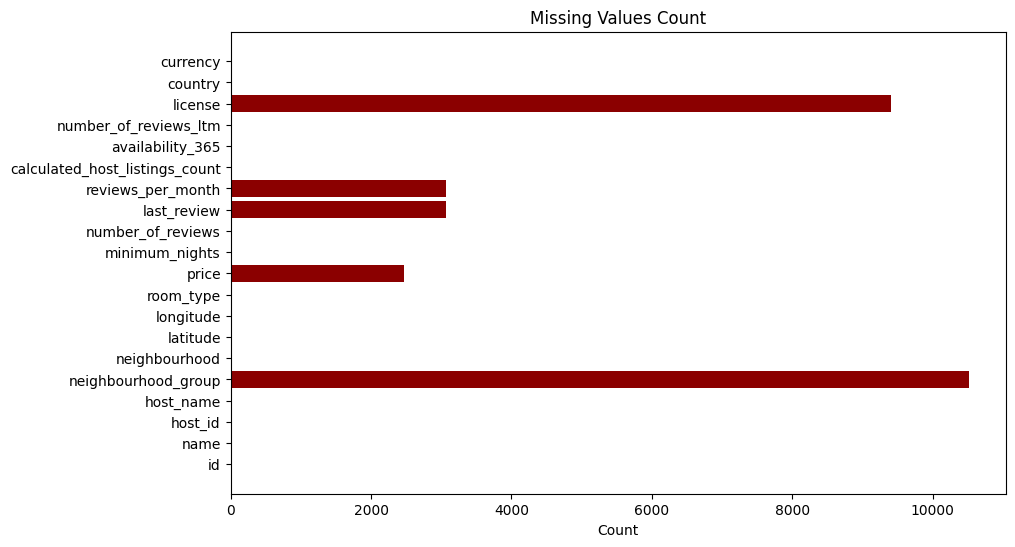

In [116]:
# Now let's plot a graph to visualise the distribution of the missing values

plt.figure(figsize=(10,6))
plt.barh(*zip(*missing_values), color='darkred')
plt.xlabel('Count')
plt.title('Missing Values Count')
plt.show()

In [96]:
# Drop columns with more than 50% missing values
columns_to_drop = [column for column, count in missing_values if count > 0.5 * listing_df.count()]

In [97]:
columns_to_drop

['neighbourhood_group', 'license']

In [167]:
# Now we can then go on to remove the columns with more than 50% missing values from listing_df by removing columns_to_drop
listing_df = listing_df.drop(*columns_to_drop)

In [168]:
# Now lets check the columns again to see
listing_df.columns

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'number_of_reviews_ltm',
 'country',
 'currency']

In [100]:
# Drops rows with ANY null values but it'll hardly help us in our case because ours isn't missing but it's written in the string nan
# in this case, we'll have to use filter, we do this in the next cell
cleaned_df = listing_df.dropna()  


In [169]:
# Define a list of values that indicate "missing" data
missing_strings = ["missing_values", "N/A", "nan", ""]  

from functools import reduce  # Import reduce
# Drop rows where ANY column contains these missing values
# Apply filter condition to all columns dynamically
cleaned_df = listing_df.filter(
    reduce(lambda a, b: a & b, [~col(c).isin(missing_strings) for c in listing_df.columns])
)


In [130]:
# Checking to see if all rows with missing values have been dropped using **Option 1:**
null_counts = [(column, cleaned_df.where(col(column).isNull()).count() + cleaned_df.where(col(column) == 'nan').count())
               for column in cleaned_df.columns]

In [131]:
null_counts

[('id', 0),
 ('name', 0),
 ('host_id', 0),
 ('host_name', 0),
 ('neighbourhood', 0),
 ('latitude', 0),
 ('longitude', 0),
 ('room_type', 0),
 ('price', 0),
 ('minimum_nights', 0),
 ('number_of_reviews', 0),
 ('last_review', 0),
 ('reviews_per_month', 0),
 ('calculated_host_listings_count', 0),
 ('availability_365', 0),
 ('number_of_reviews_ltm', 0),
 ('country', 0),
 ('currency', 0)]

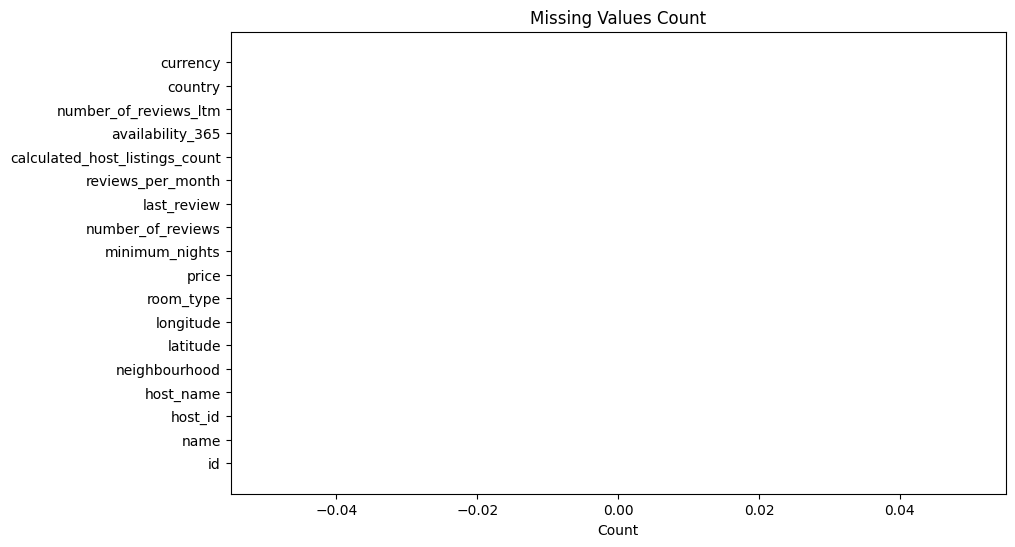

In [141]:
# Now let's plot a graph to visualise the distribution of the missing values
def visualisation():
    plt.figure(figsize=(10,6))
    plt.barh(*zip(*null_counts), color='darkred')
    plt.xlabel('Count')
    plt.title('Missing Values Count')
    plt.show()

visualisation()



# A more comprehensive version
# def visualisation():
#     fig, ax = plt.subplots(figsize=(10, 6))
#     ax.barh(missing_values_pd.columns, missing_values_pd.iloc[0], color='darkred')
#     ax.set_xlabel('Count')
#     ax.set_ylabel('Columns')
#     ax.set_title('Missing Values Count')

#     return fig  # Returns the figure object instead of displaying it

# # Example usage:
# fig = visualisation()
# fig.savefig("missing_values.png")  # Save the figure if needed



In [170]:
# Now we want to perform some form of cleaning to the currency column...
# ...the exact cleaning entails that we add currency symbols to all the unique countries
# you can run the countries distinct code to confirm how many unique countries we have
# you should also check the unique values in the currency column to see how many distinct currencies are in the dataframe, so we know how many more to add.


# Checking the unique countries
distinct_countries = cleaned_df.select('country').distinct()

In [175]:
# showing it
distinct_countries.show()

+-------------------+--------------------+---------+----------+--------------------+------------------+-------------------+---------------+------+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+--------+----------------+
|                 id|                name|  host_id| host_name|       neighbourhood|          latitude|          longitude|      room_type| price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|             country|currency|country_province|
+-------------------+--------------------+---------+----------+--------------------+------------------+-------------------+---------------+------+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+--------+----------------+
|106305821267650435

In [174]:
# now counting it, it confirms that there are 111 distinct countries
distinct_countries.count()

9876

In [204]:
# Looking through the country column, because of how its stored, it tracks not just country but states as well...
# ...that extra layer is causing more distinct country columns, even though the countries are repeted but the states are not...
# ...but we don't want that in out data...
# ...the solution is to extract the third value from the country column, if you check it, each of the third value is the actual country



from pyspark.sql.functions import split, col, regexp_replace, trim, when, size, element_at

# Extract the country/province using the last element if there is more than one element;
# otherwise, use the original (trimmed) country string.
distinct_countries = cleaned_df.withColumn("country_province",
    when(
        size(split(trim(col("country")), r",\s*")) > 1,
        trim(element_at(split(col("country"), r",\s*"), -1))
    ).otherwise(trim(col("country")))
)

# Define unwanted words to remove (adjust the list as needed)
unwanted_words = ["District", "of", "The"]
pattern = r"\b(" + "|".join(unwanted_words) + r")\b"

# Remove unwanted words and trim any extra spaces
distinct_countries = distinct_countries.withColumn("country_province", regexp_replace(col("country_province"), pattern, ""))
distinct_countries = distinct_countries.withColumn("country_province", trim(col("country_province")))

# Show results
distinct_countries.show(truncate=False)




+-------------------+-------------------------------------------------------+---------+----------+------------------------------------+------------------+-------------------+---------------+------+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+-------------------------------------------+--------+----------------+
|id                 |name                                                   |host_id  |host_name |neighbourhood                       |latitude          |longitude          |room_type      |price |minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|country                                    |currency|country_province|
+-------------------+-------------------------------------------------------+---------+----------+------------------------------------+------------------+-------------------+---------------+------+-

In [205]:
# Now we can then repeat the code to Check the unique countries
Distinct_countries = distinct_countries.select('country_province').distinct()

In [208]:
Distinct_countries.show(500)

+----------------+
|country_province|
+----------------+
|          Sweden|
|       Singapore|
|          Turkey|
|         Germany|
|          France|
|          Greece|
|          Taiwan|
|       Argentina|
|         Belgium|
|   United States|
|           China|
|           Malta|
|           Chile|
|           Italy|
|          Norway|
|           Spain|
|         Denmark|
|         Ireland|
|        Thailand|
|          Mexico|
|     Switzerland|
|          Latvia|
|          Canada|
|  Czech Republic|
|          Brazil|
|          Belize|
|           Japan|
|     New Zealand|
|        Portugal|
|       Australia|
|         Austria|
|    South Africa|
|  United Kingdom|
|     Netherlands|
+----------------+



In [207]:
# After counting, the unique countries are shown
Distinct_countries.count()

34

In [210]:
# Now we've found the exact number of countries that we're working with by checking for distinct...
# ...we should now go on to create a dictionary of those countries and their currencies, then add that to the dataframe.

# let's Check the unique currencies first so we know what we're working with
distinct_countries.select('currency').distinct().show()

+--------+
|currency|
+--------+
| unknown|
|     CNY|
+--------+



In [214]:
# creating the disctionary
currency_map = {
    "Sweden": "Swedish Krona",
    "Singapore": "Singapore Dollar",
    "Turkey": "Turkish Lira",
    "Germany": "Euro",
    "France": "Euro",
    "Greece": "Euro",
    "Taiwan": "New Taiwan Dollar",
    "Argentina": "Argentine Peso",
    "Belgium": "Euro",
    "United States": "US Dollar",
    "China": "Chinese Yuan",
    "Malta": "Euro",
    "Chile": "Chilean Peso",
    "Italy": "Euro",
    "Norway": "Norwegian Krone",
    "Spain": "Euro",
    "Denmark": "Danish Krone",
    "Ireland": "Euro",
    "Thailand": "Thai Baht",
    "Mexico": "Mexican Peso",
    "Switzerland": "Swiss Franc",
    "Latvia": "Euro",
    "Canada": "Canadian Dollar",
    "Czech Republic": "Czech Koruna",
    "Brazil": "Brazilian Real",
    "Belize": "Belize Dollar",
    "Japan": "Japanese Yen",
    "New Zealand": "New Zealand Dollar",
    "Portugal": "Euro",
    "Australia": "Australian Dollar",
    "Austria": "Euro",
    "South Africa": "South African Rand",
    "United Kingdom": "British Pound Sterling",
    "Netherlands": "Euro"
}


In [216]:
from pyspark.sql.functions import udf
from pyspark import SparkContext

# Create UDF
currency_map_udf = F.udf(lambda country: currency_map.get(country, None), StringType())

# Apply UDF to create a new column "currency"
globalStay_df = distinct_countries.withColumn("currency", currency_map_udf(col("country_province")))



# or

# Use this when you want to preserve the distinct currencies that are already in the dataframe...
# ...in this case, i'm not keeping any because we have only 1 distinct, so no point.
# globalStay_df = distinct_countries.withColumn("currency",
#     F.when(F.col("currency") == "Unknown", currency_map_udf(F.col("country")))
#     .otherwise(F.col("currency"))
# )


# Show results
globalStay_df.show()


+-------------------+--------------------+---------+----------+--------------------+------------------+-------------------+---------------+------+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+--------------------+----------------+
|                 id|                name|  host_id| host_name|       neighbourhood|          latitude|          longitude|      room_type| price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|             country|            currency|country_province|
+-------------------+--------------------+---------+----------+--------------------+------------------+-------------------+---------------+------+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+--------------------+-

### Conducting some analysis-transformation on the data

In [222]:
# The first analysis we'll do is to find out What the average listing price is for each country...
# To do this, we first have to convert the price column to a float so we can perform mathematical calculations on it
globalStay_df = globalStay_df.withColumn('price', globalStay_df['price'].cast('float'))

In [223]:
# checking the schema of the dataframe to confirm that the price is now a float
globalStay_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: float (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: string (nullable = true)
 |-- number_of_reviews_ltm: string (nullable = true)
 |-- country: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- country_province: string (nullable = true)



In [224]:
# Next is to use the converted float price to find the average
price_avg = globalStay_df.groupBy('country_province', 'currency').avg('price').show()

+----------------+--------------------+------------------+
|country_province|            currency|        avg(price)|
+----------------+--------------------+------------------+
|           Chile|        Chilean Peso| 63769.14018691589|
|          Canada|     Canadian Dollar|           164.415|
|         Germany|                Euro|197.08130081300814|
|         Austria|                Euro|112.22105263157894|
|  Czech Republic|        Czech Koruna| 5663.454545454545|
|          Brazil|      Brazilian Real| 481.5985401459854|
|          Belize|       Belize Dollar|318.82608695652175|
|     New Zealand|  New Zealand Dollar|258.96153846153845|
|         Ireland|                Euro|156.89513108614233|
|           Italy|                Euro|180.21666666666667|
|           Spain|                Euro|209.98090692124106|
|           China|        Chinese Yuan| 774.6388888888889|
|          France|                Euro|180.89836065573772|
|          Mexico|        Mexican Peso|1695.900523560209

In [225]:
# Next analysis: we want to find to total number of each of the room_types that's contained in the dataset.

# To do that, let's Check the distinct room_type first so we know what we're working with
globalStay_df.select('room_type').distinct().show()

+---------------+
|      room_type|
+---------------+
|    Shared room|
|     Hotel room|
|Entire home/apt|
|   Private room|
+---------------+



In [229]:
# Count occurrences of each distinct value in the "room_type" column
room_type_counts = globalStay_df.groupBy("room_type").count()

# Show results
room_type_counts.show()

+---------------+-----+
|      room_type|count|
+---------------+-----+
|    Shared room|   52|
|     Hotel room|   48|
|Entire home/apt| 7968|
|   Private room| 1808|
+---------------+-----+



In [248]:
# Count occurrences of each the countries with the distinct room_types
room_type_country_counts = globalStay_df.groupBy("country_province", "room_type").count().orderBy('country_province', ascending=False)

# Show results
room_type_country_counts.show()

+----------------+---------------+-----+
|country_province|      room_type|count|
+----------------+---------------+-----+
|   United States|Entire home/apt| 1452|
|   United States|   Private room|  341|
|   United States|     Hotel room|    6|
|   United States|    Shared room|    8|
|  United Kingdom|   Private room|  195|
|  United Kingdom|Entire home/apt|  423|
|  United Kingdom|     Hotel room|    1|
|  United Kingdom|    Shared room|    1|
|          Turkey|   Private room|   34|
|          Turkey|Entire home/apt|  108|
|          Turkey|     Hotel room|    2|
|        Thailand|     Hotel room|    1|
|        Thailand|   Private room|   27|
|        Thailand|    Shared room|    1|
|        Thailand|Entire home/apt|  103|
|          Taiwan|   Private room|   12|
|          Taiwan|Entire home/apt|   29|
|          Taiwan|     Hotel room|    2|
|     Switzerland|   Private room|   13|
|     Switzerland|Entire home/apt|   50|
+----------------+---------------+-----+
only showing top

In [247]:
# let's find the average price of the room types, we'll also order it by the average price
avg_price_room_type = globalStay_df.groupBy('country_province', 'room_type', 'currency').avg('price').orderBy('country_province', ascending=False)

avg_price_room_type.show()


+----------------+---------------+--------------------+------------------+
|country_province|      room_type|            currency|        avg(price)|
+----------------+---------------+--------------------+------------------+
|   United States|   Private room|           US Dollar|104.64222873900293|
|   United States|Entire home/apt|           US Dollar|  261.482782369146|
|   United States|     Hotel room|           US Dollar|             160.5|
|   United States|    Shared room|           US Dollar|             50.75|
|  United Kingdom|Entire home/apt|British Pound Ste...|216.38770685579198|
|  United Kingdom|   Private room|British Pound Ste...| 75.44102564102565|
|  United Kingdom|     Hotel room|British Pound Ste...|             292.0|
|  United Kingdom|    Shared room|British Pound Ste...|              30.0|
|          Turkey|Entire home/apt|        Turkish Lira|3538.0185185185187|
|          Turkey|   Private room|        Turkish Lira|1820.0588235294117|
|          Turkey|     Ho